In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

---

In [3]:
# Load .env enviroment variables
!pip install python-dotenv
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [4]:
# Setting ticker
list_of_tickers = ["SPY", "AGG"]

timeframe = '1D'
end_date = datetime.now()
start_date = end_date + timedelta(-365)

df = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
    
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
    
df.head()

,AGG,SPY
,close,close
time,,
2019-11-25 00:00:00-05:00,112.980,313.35
2019-11-26 00:00:00-05:00,113.120,314.02
2019-11-27 00:00:00-05:00,112.995,315.46
2019-11-29 00:00:00-05:00,112.925,314.27
2019-12-02 00:00:00-05:00,112.480,311.60


# Monte Carlo Simulation

---

In [5]:
# Caculating daily returns
daily_returns = df.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-11-25 00:00:00-05:00,NaN,NaN
2019-11-26 00:00:00-05:00,0.001239,0.002138
2019-11-27 00:00:00-05:00,-0.001105,0.004586
2019-11-29 00:00:00-05:00,-0.000619,-0.003772
2019-12-02 00:00:00-05:00,-0.003941,-0.008496


In [6]:
# Calculating average daily returns
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_agg

0.000397954823720234

In [7]:
#Calculate volatility
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_agg

0.00849621679692908

In [8]:
# Save the last day's closing price
spy_last_price = df['SPY']['close'][-1]
agg_last_price = df['AGG']['close'][-1]

In [9]:
# Setup the Monte Carlo Parameters
num_simulations = 500
number_trading_days = 252 * 30
monte_carlo = pd.DataFrame()

In [10]:
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()
# Run the simulation of projecting stock prices for the next trading year
for n in range(num_simulations):
    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    # Simulate the returns for 252 days
    for i in range(number_trading_days):
         # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
        
  # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
     # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
     # Set the portfolio weights (60% JNJ; 40% MU)
    weights = [0.60, 0.40]
    
      # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
     # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    
# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008365,0.981525,0.972129,0.996573,1.019402,1.023737,1.033360,0.984124,1.004636,0.994338,...,1.005878,0.981149,1.025399,0.997737,0.988749,1.009554,0.983278,0.974555,1.009389,0.987355
2,1.025266,0.994012,0.967407,0.990218,1.029634,0.986195,1.009226,0.941723,0.999234,1.023992,...,1.011751,1.006535,1.035166,1.001862,0.991890,0.994713,0.979214,0.973998,1.006707,0.999471
3,1.019861,0.991927,0.978331,0.966114,1.024701,0.995343,1.021988,0.917577,0.996156,1.053798,...,1.009646,1.014484,1.051155,1.005451,0.964547,0.987852,0.991193,0.992586,1.017461,0.992918
4,1.051639,1.000773,0.962912,0.985688,1.028456,0.974255,1.015110,0.905447,1.024002,1.011457,...,1.014562,1.005477,1.043173,1.022750,0.985320,0.974284,0.967578,0.993157,1.032682,1.004017


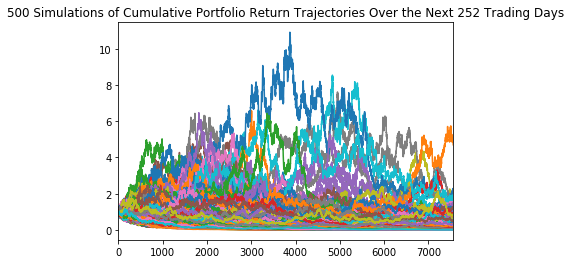

In [11]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [12]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    0.094270
1    0.044109
2    0.154348
3    0.183583
4    0.127211
Name: 7560, dtype: float64

In [13]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns20 = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns20.tail()


495    0.477577
496    0.003853
497    0.080609
498    0.853283
499    0.004393
Name: 7560, dtype: float64

In [14]:
# Display the 90% confidence interval for the ending returns
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    0.003237
0.95    0.699181
Name: 7560, dtype: float64

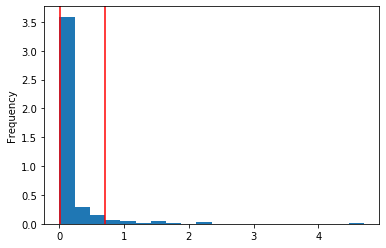

In [15]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

# Retirement Analysis

---

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [52]:
# Expected cumulative returns for 10th, 50th, 90th percentiles
percentile_10 = np.percentile(ending_cumulative_returns, 10)
percentile_50 = np.percentile(ending_cumulative_returns, 50)
percentile_90 = np.percentile(ending_cumulative_returns, 90)
print(percentile_1)
print(percentile_50)
print(percentile_90)

0.0075617061081834245
0.05020677620772136
0.3610476009627848


### Given an initial investment of $20,000, what is the expected porfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [53]:
initial_investment = 20000

portfolio_10 = round(initial_investment + (initial_investment * percentile_10), 2)
portfolio_50 = round(initial_investment + (initial_investment * percentile_50), 2)
portfolio_90 = round(initial_investment + (initial_investment * percentile_90), 2)

print(f"${portfolio_10}")
print(f"${portfolio_50}")
print(f"${portfolio_90}")

$20151.23
$21004.14
$27220.95


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

In [54]:
withdraw = round(0.04 * portfolio_10, 2) 

print(f"A 4% Withdraw will equal ${withdraw}, which does not exceed the projected annual income of $6,000.")

A 4% Withdraw will equal $806.05, which does not exceed the projected annual income of $6,000.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [58]:
new_initial_investment=30000

new_portfolio_10 = round(new_initial_investment + (new_initial_investment * percentile_10), 2)
new_portfolio_50 = round(new_initial_investment + (new_initial_investment * percentile_10), 2)
new_portfolio_90 = round(new_initial_investment + (new_initial_investment * percentile_10), 2)

new_withdraw = round(0.04 * new_portfolio_10, 2)
new_withdraw
                         
print(f'A 50% increase in the initial investment would bring the new 4% withdrawl to ${new_withdraw}.')

A 50% increase in the initial investment would bring the new 4% withdrawl to $1209.07.
